In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
from scipy.misc import derivative
import sys,json,os
import matplotlib.pyplot as plt

In [13]:
class EI_vdf:
    def __init__(self,model,**kwargs):
        """
        model = {'dm':[dm_key, param1, param2, param3],
                 'disk':[disk_key, param1, param2],
                 'bulge':[bulge_key, param1, param2]}
        """
        self.dm = model['dm'] if 'dm' in model.keys() else False
        self.disk = model['disk'] if 'disk' in model.keys() else False
        self.bulge = model['bulge'] if 'bulge' in model.keys() else False
        
        if self.dm:
            if self.dm[0] == 'MW':
                self.ρdm0,self.R0,self.rs = self.dm[1:4]
        if self.disk:
            if self.disk[0] == 'MW':
                self.ρdisk0,self.Rd,self.zd = self.disk[1:4]
        if self.bulge:
            if self.bulge[0] == 'MW':
                self.ρb0,self.rb = self.bulge[1:3]
                
        self.constants = {'G':4.302*1.0e-6} #M_sun^-1 (km/s)^2 kpc

        # radius at which mass of baryons saturates
        self.r_sat = kwargs.get('r_sat') if 'r_sat' in kwargs.keys() else 50 
        
        self.r_infinity = 1e7 # infinity..
        self.R = np.logspace(-2,7,400) # radius array
        
        Mtot = np.array([self.mass_tot(r) for r in self.R])
        self.Mtot_fun = sp.interpolate.interp1d(self.R, Mtot, kind = 'cubic', fill_value = 'extrapolate')
        Ptot = np.array([-self.pote_tot(r) for r in self.R])
        self.Ptot_fun = sp.interpolate.interp1d(self.R, Ptot, kind = 'cubic', fill_value = 'extrapolate')
        tot = np.array([self.second_derivative_fn(r) for r in self.R])
        self.second_derivative = sp.interpolate.interp1d(self.R, tot, kind = 'cubic', fill_value = 'extrapolate')

    def density_dm(self,r):
        if self.dm:
            if self.dm[0] == 'MW':
                return self.ρdm0*(self.R0/r)*((self.R0+self.rs)/(self.rs+r))**2
            else: return 0
        else: return 0
        
    def mass_bary(self,r):
        if self.disk:
            if self.disk[0] == 'MW':
                mass_disk = 2.*np.pi*self.ρdisk0*self.Rd*(self.Rd - np.exp(-r/self.Rd)*(r+self.Rd))*np.exp(self.R0/self.Rd)
            else: mass_disk = 0
        else: mass_disk = 0
        if self.bulge:
            if self.bulge[0] == 'MW':
                mass_bulge = 4*np.pi*self.ρb0*(np.arcsinh(r/self.rb)*self.rb**3-r*self.rb**4*np.sqrt(1+r**2/self.rb**2)/(r**2+self.rb**2))
            else: mass_bulge = 0
        else: mass_bulge = 0
        return mass_disk + mass_bulge
    
    def mass_dm(self,r):
        if self.dm:
            if self.dm[0] == 'MW':
                return 4*np.pi*self.ρdm0*self.R0/self.rs*(1+self.R0/self.rs)**2*self.rs**3*(np.log(1+r/self.rs)-r/(self.rs+r))
            else: return 0
        else: return 0
        
    def mass_tot(self,r):
        if r < self.r_sat:
            return self.mass_bary(r) + self.mass_dm(r)
        else:
            return self.mass_bary(self.r_sat) + self.mass_dm(r)
    
    def pote_bary(self,r):
        if r > self.r_sat:
            return -self.constants['G']*self.mass_bary(self.r_sat)/r
        else:
            integrand = lambda r_: self.mass_bary(r_)/r_**2
            t1 = quad(integrand, r, self.r_sat, limit = 10000)[0]
            t2 = self.mass_bary(self.r_sat)/self.r_sat
            return -self.constants['G']*(t1 + t2)
        
    def pote_dm(self,r):
        if self.dm:
            if self.dm[0] == 'MW':
                return -4*np.pi*self.constants['G']*self.ρdm0*self.R0/self.rs*(1+self.R0/self.rs)**2*self.rs**3*np.log(1+r/self.rs)/r
            else: return 0
        else: return 0
        
    def pote_tot(self,r):
        return self.pote_bary(r) + self.pote_dm(r)

    def Vmax(self,r):
        return np.sqrt(2*self.Ptot_fun(r))
    
    def second_derivative_fn(self,r):
        density_1st_derivative = lambda r_: sp.misc.derivative(self.density_dm,r_, dx = 1e-3, order = 3)
        potential_1st_derivative = lambda r_: -self.constants['G']*self.Mtot_fun(r_)/r_**2
        first_derivative = lambda r_: density_1st_derivative(r_)/potential_1st_derivative(r_)
        return -derivative(first_derivative, r, dx = 1e-6, order = 3)
    
    def get_vdf(self,r,n=32):
        self.n = n
        vesc = self.Vmax(r)
        v = np.arange(0,vesc+vesc/(self.n-1),vesc/(self.n-1))
        
        pote_here = self.Ptot_fun(r)
        Ene = np.array([pote_here-0.5*v_**2 for v_ in v])
        
        Rz = np.ones(self.n)
        for i in range(0,self.n-1,1):
            def eqsn(x):
                return self.Ptot_fun(x) - Ene[i]
            Rz[i] = sp.optimize.fsolve(eqsn,x0 = r)
        
        I = np.zeros(self.n)
        for i in range(0,self.n-1,1):
            def integrand(x):
                x = np.array(x)
                return self.second_derivative(x)*(1/(np.sqrt(8)*np.pi**2))/np.sqrt(np.abs(Ene[i]-self.Ptot_fun(x)))
            I[i] = quad(integrand,Rz[i],1000*Rz[i],points = Rz[i],limit = 10000)[0]
            
        vdist = I/self.density_dm(r)
        distr = 4.*np.pi*v**2*vdist
        vdf = np.vstack((v,distr))
        return vdf.transpose()

In [3]:
gev_by_cc = 1.7827 * (3.08**3) * 1e6/ 1.989 # Msun kpc^-3

Normalization = 1.00006791


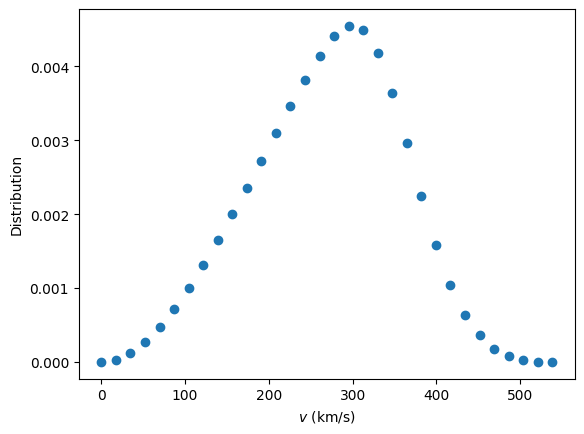

In [14]:
model = {'dm':['MW', 0.09*gev_by_cc, 8.5, 74.582],
         'disk':['MW', 5.24*gev_by_cc, 4.251, 0.34],
         'bulge':['MW', 11120*gev_by_cc, 0.0905]}
ei = EI_vdf(model)
vdf = ei.get_vdf(10,n = 32)
print ('Normalization = %.8f'%np.trapz(vdf[:,1],vdf[:,0]))
plt.scatter(vdf[:,0],vdf[:,1])
plt.ylabel('Distribution')
plt.xlabel('$v$ (km/s)');